GANs worksheet

This worksheet shows an implementation of GANs.
Pytorch is used to implement the Neural network and backpropagation.

The different lossfunctions are implemented by hand.

The goal of this worksheet is to explain how GANs work in very simple applications.

In [617]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn

from tqdm import tqdm

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)


The goal of the GAN in this worksheet is to map samples from one distribution to another distribution.

First two distributions are defined. The first is the distribution of the prior:
With probability density function: 
\begin{equation*} 
P_z(\textbf{z})\text{ with }z\in \mathbb{R}^{n\times m}\text{  (or higher dimensions)}
\end{equation*}
This distribution is defined as a normal distribution.

The second distribution acts as the real data.
From this distribution samples are taken during the training process.
\begin{equation*} 
P_{data}(\textbf{x})\text{ with }\textbf{x}\in \mathbb{R}^{n\times m}\text{  (or higher dimensions)}
\end{equation*}

Here n is the number of elements in a single sample (or realization) and m is the number of samples (or realizations).

In [618]:
def noisesample(size,mu=10,sigma=0.1):
    """Generate realizations of the prior noise.
    """
    return np.random.normal(mu,sigma,size)
    #return np.random.uniform(0,1,size)

def data_distribution(size,mu=2,sigma=0.1):
    """Generate realizations from the data distribution.
    This function acts as data generator.
    """
    return np.random.normal(mu,sigma,size)

def test_sampling(mode,size=1):
    if mode == "noise":
        print(noisesample(size))
    elif mode == "data":
        print(data_distribution(size))
    elif mode == "show":
        d1 = {'Real':data_distribution(100),'Fake':noisesample(100)}
        data = pd.DataFrame(data=d1)
        sns.displot(data=data,kind='kde')
    else:
        print("Unknown mode, try \"noise\", \"data\" or \"show\"")
print("Example of 2 noissamples of size 5")
test_sampling("noise",[5,2])
#test_sampling("show")

Example of 2 noissamples of size 5
[[10.13560306  9.9466336 ]
 [10.03349278  9.96633128]
 [ 9.98141167  9.9268577 ]
 [ 9.83840424 10.02589233]
 [ 9.89748919  9.9800826 ]]


In [619]:
arraylength = 100
gen_n_input = arraylength
gen_n_hidden = 1
gen_n_out = arraylength
dis_n_input = arraylength
dis_n_hidden = 1
dis_n_out =1

Generator = nn.Sequential(#nn.Linear(gen_n_input, gen_n_hidden),
                        #nn.ReLU(),
                        #   nn.Linear(n_hidden, n_hidden),
                        #   nn.ReLU(),
                        #   nn.Linear(n_hidden, n_hidden),
                        #   nn.ReLU(),
                        nn.Linear(gen_n_input, gen_n_out),
                        nn.ReLU()).to(dev)
Discriminator = nn.Sequential(#nn.Linear(dis_n_input, dis_n_hidden),
                        #nn.ReLU(),
                        #   nn.Linear(n_hidden, n_hidden),
                        #   nn.ReLU(),
                        nn.Linear(dis_n_input, 1),
                        nn.Sigmoid()).to(dev) #end in sigmoid because output should be between 0 and 1
# def weight_reset(m):
#     if isinstance(m, nn.Linear):
#         m.reset_parameters()
# Generator.apply(weight_reset)
# Discriminator.apply(weight_reset)
#print(Generator)
# for param in Generator.parameters():
#    print(param.data)
print("Putting a single data sample in to the discrimenator network gives a value between 0 and 1. e.g.:")
print(Discriminator(torch.from_numpy(data_distribution([1,arraylength])).float().to(dev)).item())

Putting a single data sample in to the discrimenator network gives a value between 0 and 1. e.g.:
0.2964479625225067


In [620]:
#Use untrained generator to show difference before and after training
m=[1000,arraylength]
z = torch.from_numpy(noisesample(m)).float().to(dev)
fakedata=np.concatenate(Generator(z).data.tolist())
d1 = {'Generated-BT':fakedata,'Noise Distribution':noisesample(m[0]*m[1]),'Data Distribution':data_distribution(m[0]*m[1])}
distribution_sims = pd.DataFrame(data=d1)

# Loss funcions
The complet loss function is given as:
\begin{equation}
V(D,G)=\mathbb{E}_{\textbf{x} \sim p_{data}(\textbf{x})}[log(D(\textbf{x}))] + \mathbb{E}_{\textbf{z} \sim p_{z}(\textbf{z})}[log(1-D(G(\textbf{z})))]
\end{equation}
This functions is iterativly maximized for D and minimized for G.
\begin{equation}
\nabla_{\theta_d}\frac{1}{m}\sum_{i=1}^m[log(D(x^{(i)}))+log(1-D(G(\textbf{z}^{(i)})))]
\end{equation}

\begin{equation}
\nabla_{\theta_g}\frac{1}{m}\sum_{i=1}^m log(1-D(G(\textbf{z}^{(i)})))
\end{equation}



In [621]:
def tot_loss(m):
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost = torch.mean(torch.log(Generator(x)).to(dev)) - torch.mean(torch.log(1-Discriminator(Generator(z)).to(dev))).to(dev)
    return cost
def dis_loss(m):
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost_d = torch.mean(torch.log(Discriminator(x))+(torch.log(1-Discriminator(Generator(z)))))
    return -1*cost_d
def dis_lossR(m):
    """Calculates loss based on only real data"""
    x = torch.from_numpy(data_distribution(m)).float().to(dev)
    return torch.mean(torch.log(Discriminator(x)))
def dis_lossF(m):
    """Calculates loss based on only fake data"""
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    return torch.mean(torch.log(1-Discriminator(Generator(z))))
def gen_loss(m):
    z = torch.from_numpy(noisesample(m)).float().to(dev)
    cost_g = torch.mean(torch.log(1-Discriminator(Generator(z))))
    #cost_g = -1*torch.mean(torch.log(Discriminator(Generator(z))))
    return cost_g

print(dis_loss([100,arraylength]).item())
x = torch.from_numpy(data_distribution(m)).float().to(dev)
z = torch.from_numpy(noisesample(m)).float().to(dev)

#print(x)
loss = -1*torch.mean(torch.log(Discriminator(x))+(torch.log(1-Discriminator(Generator(z)))))


1.2669988870620728


In [622]:
lr=0.01
gen_opt = torch.optim.SGD(Generator.parameters(),lr)
dis_opt = torch.optim.SGD(Discriminator.parameters(),lr)

100%|██████████| 500/500 [00:03<00:00, 136.82it/s]


<AxesSubplot:>

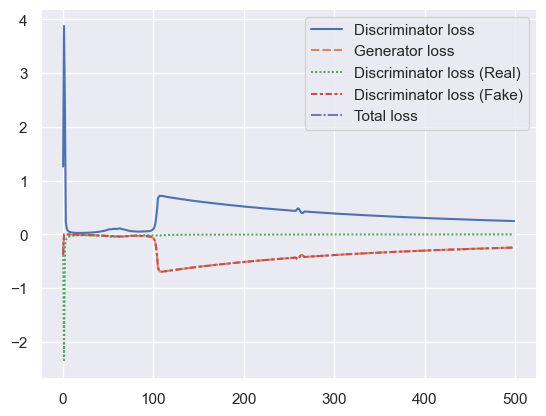

In [623]:
m = [100,arraylength] #batchsize
maxiter = 500
gen_losses = []
dis_losses = []
dis_lossesR = []
dis_lossesF = []
tot_losses = []
for iter in tqdm(range(maxiter)):
    #loss = tot_loss(m)
    #tot_losses.append(loss.item())
    # discriminator update
    for k in range(1):
        dis_opt.zero_grad()
        loss = dis_loss(m)
        # if loss.item()<= 0.5:
        #     break
        loss.backward()
        #print(loss)
        dis_opt.step()
        tot_losses.append(tot_loss(m).item())
        dis_losses.append(loss.item())
        dis_lossesR.append(dis_lossR(m).item())
        dis_lossesF.append(dis_lossF(m).item())
        gen_losses.append(gen_loss(m).item())
    # generator update
    for k in range(1):
        gen_opt.zero_grad()
        loss = gen_loss(m)
        #gen_losses.append(loss.item())
        loss.backward()
        gen_opt.step()
#sns.lineplot(data=[dis_losses,gen_losses,tot_losses])
d1 = {'Discriminator loss':dis_losses,
      'Generator loss': gen_losses, 
      'Discriminator loss (Real)':dis_lossesR, 
      'Discriminator loss (Fake)':dis_lossesF,
      'Total loss': tot_losses}
losses = pd.DataFrame(data=d1)
sns.lineplot(data=losses)
#axis labels!
#sns.lineplot(dis_losses)

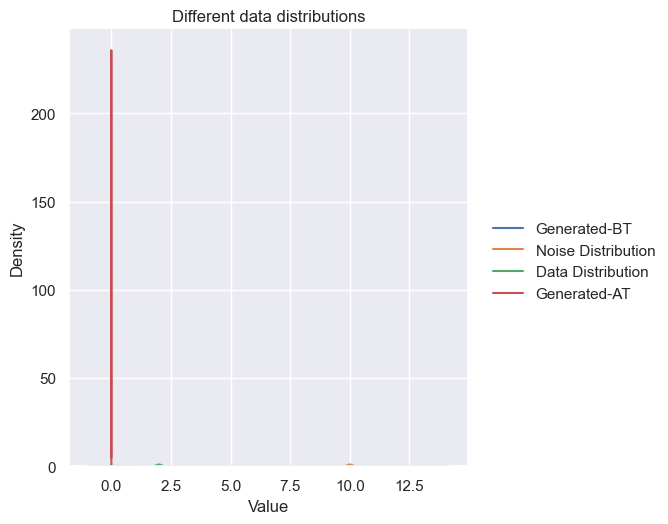

In [629]:
# add trained generator distribution to data and plot
m=[1000,arraylength]
z = torch.from_numpy(noisesample(m)).float().to(dev)
distribution_sims['Generated-AT'] = np.transpose(np.concatenate(Generator(z).data.tolist()))

#sns.displot(data=distribution_sims[["Generated-BT","Generated-AT"]],kind="kde")
sns.set_style("darkgrid")
ax=sns.displot(data=distribution_sims,kind="kde")
ax.set(xlabel='Value',title='Different data distributions')

In [625]:
print(Discriminator(torch.from_numpy(data_distribution([10,arraylength])).float().to(dev)))
print(Discriminator(torch.from_numpy(noisesample([10,arraylength])).float().to(dev)))

for param in Generator.parameters():
   print(param.data)

tensor([[0.9988],
        [0.9987],
        [0.9989],
        [0.9987],
        [0.9988],
        [0.9989],
        [0.9988],
        [0.9989],
        [0.9989],
        [0.9989]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[-0.0152, -0.0846,  0.0079,  ...,  0.0420, -0.0342,  0.0873],
        [-0.0928,  0.0292,  0.0280,  ...,  0.0589,  0.0708, -0.0090],
        [ 0.0889, -0.0069, -0.0825,  ..., -0.0085,  0.0189, -0.0893],
        ...,
        [ 0.0622, -0.0358,  0.0805,  ...,  0.0347,  0.0223,  0.0248],
        [ 0.0069,  0.0988, -0.0844,  ...,  0.0808, -0.0900, -0.0410],
        [ 0.0737,  0.0912,  0.0183,  ...,  0.0686,  0.0189,  0.0705]],
       device='cuda:0')
tensor([-0.0485,  0.0712, -0.0162, -0.0758, -0.0212,  0.0202,  0.0504,  0.0474,
        -0.0661,  0.0149,  0.0474,  0.0551,  0.083